# The opportunity and cost of the ability of neural networks to solve any problem
*When do we choose linear regression over neural networks?*

When I first started to learn statistics in university, all statistical models seemed to be unique tools in their own right. Completely separate islands of knowledge: we used linear regression to predict the amount of soil erosion on a given hill slope, and [kriging](https://en.wikipedia.org/wiki/Kriging) to spatially interpolate radiation values. However, after some time I realized that kriging is just a specific variant of linear regression where the observations are spatially correlated to each other. 

Neural networks especially have this almost mythical sense of uniqueness over them: these magic black box models that solve problems never before thought possible to solve. But even neural networks have strong ties back to classical statistics. In this article I want to explore some of these ties, and what they say about the generalizing nature of neural networks. I use the term generalizing here in the sense that a neural network presents a more general class of models, being able to mimic many other statistical models. More importantly, when training the neural network it effectively chooses which model to mimic, or create its own blend of models. This chameleon-like quality allows a neural network to find the appropriate solution given the problem its presented. 

All this mimicry prowess begs the question: why should you ever not use a neural network? To answer this question we will start off with building a fuel effiency model that nicely links various forms of linear regression to neural networks. 

This article and the code can be found [on github](https://github.com/PaulHiemstra/neuralnet_generalisation/blob/main/neuralnetworks_generalisation.ipynb).  

# Fuel efficieny models
This case is built on the classic mtcars dataset inspired by [a tutorial](https://www.tensorflow.org/tutorials/keras/regression), where we specifically focus on the relationship between the weight of the car and the fuel usage in miles-per-gallon (`MPG`):

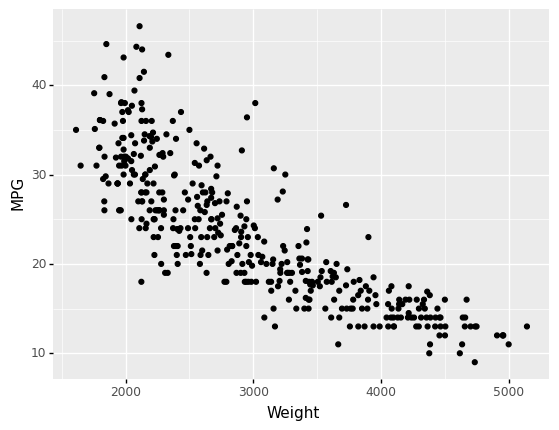

<ggplot: (8780832701410)>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from plotnine import *

mtcars = pd.read_csv('mtcars.csv')
(
    ggplot(mtcars) + geom_point(aes(x='Weight', y='MPG'))
)

where we see that a lighter car is more fuel efficient. This makes sense as the car does not have to drag along all the addition weight. 

To explore how neural networks present a more general class of models, we will implement the following very simple network architectures and compare those to ordinary least squares (OLS) linear regression from the `statsmodels` package. 

![](network_options.png)

We will first start off comparing network **a** to OLS from statsmodels. 

# OLS as a neural network
Network **a** essentially behaves exactly like linear regression. Actally running the model shows just how true this exactly is. 

First we need to normalize the data, without it Keras has a hard time fitting a good model. In addition, we split the data into a training and test set. 

In [2]:
from tensorflow.keras.layers import Normalization
from sklearn.model_selection import train_test_split

# This needs to be added in front, or the solution will be very unstable
normalizer = Normalization(input_shape=[1,], axis=None)
normalizer.adapt(mtcars['Weight'])

mtcars['Weight_norm'] = np.array(normalizer(mtcars['Weight'])).flatten()
train_data, test_data = train_test_split(mtcars, test_size=0.1)

2022-03-20 10:58:03.472874: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


With the data ready, we can build both model **a** and the OLS model. 

In [3]:
# KERAS MODEL ---------------
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense

keras_mpg_weight = Sequential([ 
    Input(shape=(1,)), 
    Dense(units=1)
])

keras_mpg_weight.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mean_squared_error')

history = keras_mpg_weight.fit(
    train_data['Weight_norm'], train_data['MPG'],
    epochs=100, verbose=0, validation_split = 0.2)

# STATSMODEL OLS ---------------
from statsmodels.formula.api import ols

train_data['Weight_norm'] = np.array(normalizer([train_data['Weight']])).flatten()
ols_mpg_weight = ols("MPG ~ Weight_norm", data=train_data).fit()

Looking at the fitted coefficients of both the OLS and neural network we can see that they are roughly the same with an intercept of around -6.5 and a slope of 23.5:

In [4]:
print(keras_mpg_weight.get_weights())
print(ols_mpg_weight.params)

[array([[-6.6114306]], dtype=float32), array([23.516169], dtype=float32)]
Intercept      23.495049
Weight_norm    -6.500213
dtype: float64


So network **a** essentially is OLS linear regression.  

# Introducing non-linearity: polynomial regression
The relationship between weight and fuel efficiency seems not completely lineair, but tapers off slightly for higher weight cars. We can take this into account by trying to fit a quadratic line. This is exactly what network **b** does by inputting both the weight and the square of the weight as separate features into the network ([inspired by](https://medium.com/analytics-vidhya/polynomial-regression-with-keras-ef1797b39b88)):

In [28]:
from sklearn.preprocessing import PolynomialFeatures

def create_poly_features(series, n):
    poly = PolynomialFeatures(n)
    return poly.fit_transform(np.expand_dims(series, axis=1))

n = 2  # Use quadratic polynomial regression
keras_mpg_weight_poly = Sequential([ 
    Input(shape=(n+1,)), 
    Dense(units=1)
])

keras_mpg_weight_poly.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mean_squared_error')

history = keras_mpg_weight_poly.fit(
    create_poly_features(train_data['Weight_norm'], n), train_data['MPG'],
    epochs=100, verbose=0, validation_split = 0.2)

Plotting the predicted lines for network **b** and OLS with the data nicely illustrates what happens:

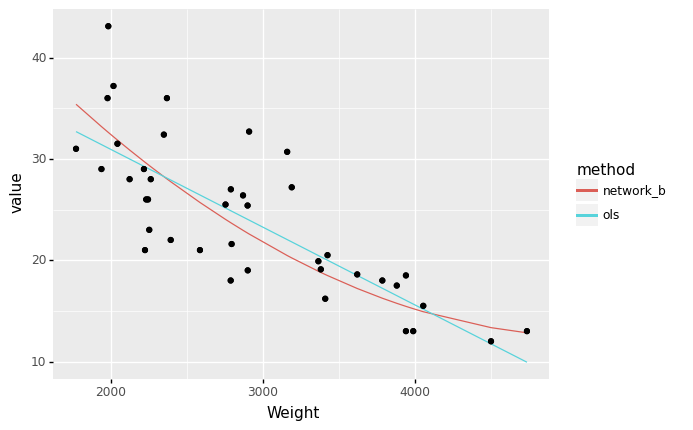

<ggplot: (8780679230955)>

In [31]:
prediction_results = pd.DataFrame({'network_b' : keras_mpg_weight_poly.predict(create_poly_features(test_data['Weight_norm'], n)).flatten(),
                                   'ols'       : ols_mpg_weight.predict(test_data['Weight_norm']),
                                   'reference' : test_data['MPG'], 
                                   'Weight'    : test_data['Weight']})

plt_data = prediction_results.sort_values('Weight').melt(id_vars=['reference', 'Weight'], var_name='method')
(
    ggplot(plt_data, aes(x='Weight')) 
      + geom_path(aes(y='value', color='method'))
      + geom_point(aes(y='reference'))
)

Showing that network **b** essentially boils down to quadratic linear regression. 

# The magic of neural networks
The issue with network **b** is that we still had to manually decide to fit a polynomial regression by feeding the network more features. For me, the real magic of neural networks is the ability to let the data inform the actual functional form of the relationship in stead of having to make that choice manually. Network **c** introduces this flexibility by using a *hidden layer* of in this case 8 neurons:

In [24]:
keras_mpg_weight_2layers = Sequential([ 
    Input(shape=(1,)), 
    Dense(units=8, activation='relu'),   # <---- extra hidden layer
    Dense(units=1)
])

keras_mpg_weight_2layers.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mean_squared_error')

history = keras_mpg_weight_2layers.fit(
    train_data['Weight_norm'], train_data['MPG'],
    epochs=100, verbose=0, validation_split = 0.2)

The hidden layer allows the network to discover on its own what kind of combination of input features yield the best results, no need to manually create features. The following figure plots the lines for the networks **b**, **c** and OLS:

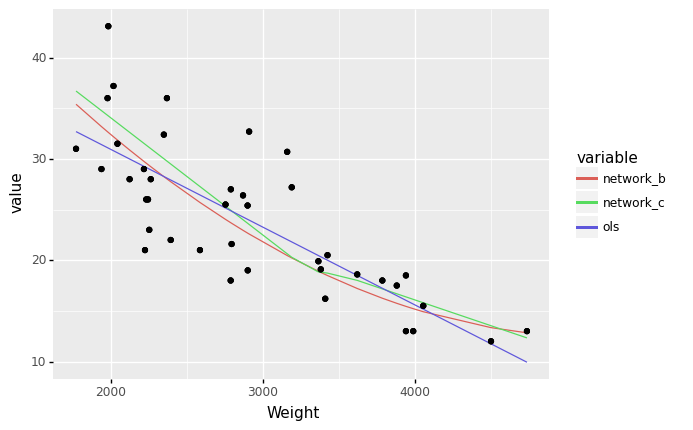

<ggplot: (8780679168549)>

In [33]:
prediction_results = pd.DataFrame({'network_b' : keras_mpg_weight_poly.predict(create_poly_features(test_data['Weight_norm'], n)).flatten(),
                                   'network_c' : keras_mpg_weight_2layers.predict(test_data['Weight_norm']).flatten(),
                                   'ols'       : ols_mpg_weight.predict(test_data['Weight_norm']),
                                   'reference' : test_data['MPG'], 
                                   'Weight'    : test_data['Weight']})

plt_data = prediction_results.sort_values('Weight').melt(id_vars=['reference', 'Weight'])
(
    ggplot(plt_data, aes(x='Weight')) 
      + geom_path(aes(y='value', color='variable'))
      + geom_point(aes(y='reference'))
)

The solution that model **c** came up with is even more intricate than the quadratic linear regression, looking more like a form of local regression. 

# Neural networks as a generalisation
The example of the fuel efficiency models nicely illustrates that a neural network can mimic any function between input and output, including all kinds of (local) regression. This is what I meant that neural networks present a more general class of models. More importantly, it can choose on the fly which kind of regression is suitable given the data we have observed. 

This concept of generalisation is taken even further when using deep neural networks. These deep networks can solve problems that would be impossible to solve using more classical statistical problems. For example, how should we derive features from a set of images containing cats and dogs such that a logistic regression can efficiently see the difference between the cats and dogs. Deep neural networks are amazing at discovering what representation in layers of features best allows us to see the difference. 

# But what is the trade-off?
After such a glowing description extolling the virtues of (deep) neural networks, why would we ever use anything other than neural networks? I see the following challenges for neural networks:

- *Flexibility versus compute and data*. Neural networks typically use a lot more coefficients to describe the problem than more traditional methods. This allows for the awesome flexibility, but requires a lot more computation and data to actually discover what the values for all those coefficients should be. For your use-case a more traditional method could be the better option given your computational resources or amount of data.  
- *To a hammer, each problem is a nail*. When we focus too much on using neural networks as a default, we can become blind to much simpler and efficient solutions. For example, we could use a recurrent deep neural network to try and classify which department of the company a support e-mail should be forwarded. [However, a simple set of regular expressions might perform a lot better if we would have tried that](https://www.linkedin.com/posts/rohankamath_i-was-a-part-of-the-fraud-detection-team-activity-6907684110697943040-0isE?utm_source=linkedin_share&utm_medium=member_desktop_web). Learn about all the models that exist out there, and why they make sense in a given context. Then make the smart choice which model suits your problem.
- *Interpretability*. The large amount of interacting coefficients make it hard to explain why a particlar choice is made by the model. For a lot of use cases this might nog be an issue, but for example in medical applications this can pose a real challenge. A doctor might not be willing to use the model if they do not understand why it makes certain decisions. The opposite effect can also occur: the lack of interpretability can cause the model to be followed without question. There certainly [are ways](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence) to make (deep) neural less opaque, but an OLS with a few coefficients is much easier to explain. This especially holds for a non-technical audience. 
- *Familiarity*. In your given context, neural networks might be rarely used. Using the models that everyone else uses makes it much more likely to be accepted and have impact. A fancy neural network might work even better, but you have to earn the trust of the people around you first. 

In general my advice would be to keep an open mind, and look broadly at all the possible statistical techniques that you can use. Do not get sucked into the tempting vortex of machine learning awesomeness, and choose the right tool for the job. 